In [1]:
##
## Dataset
##

In [2]:
from time import perf_counter
import torch.nn as nn
import torch
import numpy as np

In [3]:
device = 'mps'

In [4]:
from RawRefinery.train.SmallRawDataset import SmallRawDataset

In [5]:
dataset  = SmallRawDataset('/Volumes/EasyStore/RAWNIND/JPEGs/Cropped_JPEG/', 'align_data.csv', crop_size=256)

In [6]:
from torch.utils.data import DataLoader, random_split
import torch
batch_size = 4
val_split = 0.2
# Split dataset into train and val
val_size = int(len(dataset) * val_split)
train_size = len(dataset) - val_size
torch.manual_seed(42)  # For reproducibility
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [7]:
class NanoEncoder(nn.Module):
    def __init__(self, in_channels=3, channels = [16, 32, 64, 128]):
        """
        Args:
            in_channels: number of input channels (e.g. 3 for RGB)
            channels: the output channels for each layer
        """
        super().__init__()

        layers = []
        for out_channels in channels:
            layers += [
                nn.Conv2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.GroupNorm(1, out_channels),
                nn.ReLU(inplace=True)
            ]
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)


    def forward(self, x):
        x = self.encoder(x)
        return x


In [8]:
enc = NanoEncoder(channels = [16, 32, 64])

enc(torch.rand(1, 3, 256, 256)).shape

torch.Size([1, 64, 32, 32])

In [9]:
from RawRefinery.model.Cond_NAFNet import NAFBlock0
class ScaleAndProcess(nn.Module):
    def __init__(self, in_chan, width, out_chan, n_blocks, enc_channels = [8, 16, 32, 64], cond_chans=1):
        super().__init__()
        scale = 2**len(enc_channels)
        # padding = min(scale // 2 - 1, 0)
        self.scale = scale
        self.in_conv = NanoEncoder(channels = enc_channels) #nn.Conv2d(in_chan, width, scale, scale, padding)
        self.blocks = nn.Sequential(
            *[NAFBlock0(width, cond_chans=1) for _ in range(n_blocks)]
        )
        self.out_conv = nn.Conv2d(width, out_chan, 1, 1, 0)
    
    def forward(self, input):
        in_image, cond = input
        x = self.in_conv(in_image)
        output = self.blocks((x, cond))[0]
        reduced_image = torch.nn.functional.interpolate(in_image, scale_factor=1/self.scale)
        out_image = self.out_conv(output) + reduced_image
        return output, out_image, reduced_image



In [10]:
class GRN(nn.Module):
    """ GRN (Global Response Normalization) layer
    """
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, 1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, 1, dim))

    def forward(self, x):
        Gx = torch.norm(x, p=2, dim=(1,2), keepdim=True)
        Nx = Gx / (Gx.mean(dim=-1, keepdim=True) + 1e-6)
        return self.gamma * (x * Nx) + self.beta + x

In [12]:
class SimpleGate(nn.Module):
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        return x1 * x2


class ConditionedChannelAttention(nn.Module):
    def __init__(self, dims, cat_dims):
        super().__init__()
        in_dim = dims + cat_dims
        self.mlp = nn.Sequential(nn.Linear(in_dim, dims))
        self.pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x, conditioning):
        pool = self.pool(x)
        conditioning = conditioning.unsqueeze(-1).unsqueeze(-1)
        cat_channels = torch.cat([pool, conditioning], dim=1)
        cat_channels = cat_channels.permute(0, 2, 3, 1)
        ca = self.mlp(cat_channels).permute(0, 3, 1, 2)

        return ca 
    

class ConditionedChannelAttentionWrapper(nn.Module):
    def __init__(self, dims, cat_dims):
        super().__init__()
        self.CCAW = ConditionedChannelAttention(dims, cat_dims)
    def forward(self, input):
        inp = input[0]
        cond = input[1]
        x = self.CCAW(inp, cond)
        return (inp * (1 + x), cond)


class NKA(nn.Module):
    def __init__(self, dim, channel_reduction = 8):
        super().__init__()

        reduced_channels = dim // channel_reduction
        self.proj_1 = nn.Conv2d(dim, reduced_channels, 1, 1, 0)
        self.dwconv = nn.Conv2d(reduced_channels, reduced_channels, 3, 1, 1, groups=reduced_channels)
        self.proj_2 = nn.Conv2d(reduced_channels, reduced_channels * 2, 1, 1, 0)
        self.sg = SimpleGate()
        self.attention = nn.Conv2d(reduced_channels, dim, 1, 1, 0)
        
    def forward(self, x):
        B, C, H, W = x.shape
        # First projection to a smaller dimension
        y = self.proj_1(x)
        # DW conv
        attn = self.dwconv(y)
        # PW back to orignal space
        attn = self.proj_2(attn)
        # Non-linearity
        attn = self.sg(attn)
        # Apply attention map
        out = x * self.attention(attn)
        return out
    
    
class ConvNextStyle(nn.Module):
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6, cond_chans=1):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.sca = ConditionedChannelAttention(dim, cond_chans)
        self.norm = nn.GroupNorm(1, dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.grn = GRN(4 * dim)
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)), 
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = nn.Identity()

    def forward(self, x_cond):
        x = x_cond[0]
        cond = x_cond[1]
        input = x
        x = self.dwconv(x)
        x = self.sca(x, cond) * x
        x = self.norm(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return (x, cond)
    

    class DoubleConv(nn.Module):
    def __init__(self, chan, cond_chans=0, r=16):
        super().__init__()
        self.nka =  NKA(c)
        self.dwconv = nn.Conv2d(chan, chan, 3, 1, 1, groups=chan)
        self.pwconv = nn.Conv2d(chan, chan, 1, 1, 0)


        self.act = nn.ReLU()

        self.dwconv2 = nn.Conv2d(chan, chan, 3, 1, 1, groups=chan)
        self.pwconv2 = nn.Conv2d(chan , chan, 1, 1, 0)
        
        self.sca = ConditionedChannelAttention(chan, cond_chans)
        
        self.beta = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.norm = nn.GroupNorm(1, chan)
    def forward(self, input):
        in_x = input[0]
        in_cond = input[1]
        x = self.norm(in_x)
        
        # DW conv
        x = self.NKA(y)
        x = self.dwconv(x)
        x = self.pwconv(x)


        x = self.sca(x, in_cond) * x
        x = self.act(x)
        # DW conv
        x = self.dwconv2(x)
        x = self.pwconv2(x)   
        x = self.act(x)
        return (in_x + self.beta*x, in_cond)
    

    class CHASPABlock(nn.Module):
    def __init__(self, c, DW_Expand=2, FFN_Expand=2, drop_out_rate=0.0, cond_chans=0):
        super().__init__()
        dw_channel = c * DW_Expand

        self.NKA = NKA(c)
        self.conv1 =  nn.Conv2d(
            in_channels=c,
            out_channels=c,
            kernel_size=3,
            padding=1,
            stride=1,
            groups=c,
            bias=True,
        )

        # Simplified Channel Attention
        self.sca = ConditionedChannelAttention(dw_channel // 2, cond_chans)

        # SimpleGate
        self.sg = SimpleGate()

        ffn_channel = FFN_Expand * c
        self.conv2 = nn.Conv2d(
            in_channels=c,
            out_channels=ffn_channel,
            kernel_size=1,
            padding=0,
            stride=1,
            groups=1,
            bias=True,
        )
        self.conv3 = nn.Conv2d(
            in_channels=ffn_channel // 2,
            out_channels=c,
            kernel_size=1,
            padding=0,
            stride=1,
            groups=1,
            bias=True,
        )

        # self.grn = GRN(ffn_channel // 2)

        self.norm1 = LayerNorm2d(c)
        self.norm2 = LayerNorm2d(c)

        self.dropout1 = (
            nn.Dropout(drop_out_rate) if drop_out_rate > 0.0 else nn.Identity()
        )
        self.dropout2 = (
            nn.Dropout(drop_out_rate) if drop_out_rate > 0.0 else nn.Identity()
        )

        self.beta = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)
        self.gamma = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)

    def forward(self, input):
        inp = input[0]
        cond = input[1]

        x = inp
        x = self.norm1(x)

        # Channel Mixing
        x = self.conv2(x)
        x = self.sg(x)
        x = x * self.sca(x, cond)
        x = self.conv3(x)
        x = self.dropout2(x)
        y = inp + x * self.beta

        #Spatial Mixing
        x = self.NKA(self.norm2(y))
        x = self.conv1(x)
        x = self.dropout1(x)
        

        return (y + x * self.gamma, cond)
    
class NAFBlock0(nn.Module):
    def __init__(self, c, DW_Expand=2, FFN_Expand=2, drop_out_rate=0.0, cond_chans=0):
        super().__init__()
        dw_channel = c * DW_Expand
        self.conv1 = nn.Conv2d(
            in_channels=c,
            out_channels=dw_channel,
            kernel_size=1,
            padding=0,
            stride=1,
            groups=1,
            bias=True,
        )
        self.conv2 = nn.Conv2d(
            in_channels=dw_channel,
            out_channels=dw_channel,
            kernel_size=3,
            padding=1,
            stride=1,
            groups=dw_channel,
            bias=True,
        )
        self.conv3 = nn.Conv2d(
            in_channels=dw_channel // 2,
            out_channels=c,
            kernel_size=1,
            padding=0,
            stride=1,
            groups=1,
            bias=True,
        )

        # Simplified Channel Attention
        self.sca = ConditionedChannelAttention(dw_channel // 2, cond_chans)

        # SimpleGate
        self.sg = SimpleGate()

        ffn_channel = FFN_Expand * c
        self.conv4 = nn.Conv2d(
            in_channels=c,
            out_channels=ffn_channel,
            kernel_size=1,
            padding=0,
            stride=1,
            groups=1,
            bias=True,
        )
        self.conv5 = nn.Conv2d(
            in_channels=ffn_channel // 2,
            out_channels=c,
            kernel_size=1,
            padding=0,
            stride=1,
            groups=1,
            bias=True,
        )

        # self.grn = GRN(ffn_channel // 2)

        self.norm1 = LayerNorm2d(c)
        self.norm2 = LayerNorm2d(c)

        self.dropout1 = (
            nn.Dropout(drop_out_rate) if drop_out_rate > 0.0 else nn.Identity()
        )
        self.dropout2 = (
            nn.Dropout(drop_out_rate) if drop_out_rate > 0.0 else nn.Identity()
        )

        self.beta = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)
        self.gamma = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)

    def forward(self, input):
        inp = input[0]
        cond = input[1]

        x = inp

        x = self.norm1(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.sg(x)
        x = x * self.sca(x, cond)
        x = self.conv3(x)

        x = self.dropout1(x)

        y = inp + x * self.beta

        # Channel Mixing
        x = self.conv4(self.norm2(y))
        x = self.sg(x)
        # x = self.grn(x)
        x = self.conv5(x)

        x = self.dropout2(x)

        return (y + x * self.gamma, cond)

IndentationError: expected an indented block after class definition on line 94 (3488572878.py, line 95)

In [13]:
class ConvNextStylePlus(nn.Module):
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6, cond_chans=1):
        super().__init__()
        reduced_dims = dim//2
        self.reduce_conv = nn.Conv2d(dim, reduced_dims, 2, 2)
        self.reduce_block = ConvNextStyle(reduced_dims, cond_chans=1)
        self.expand_conv = nn.ConvTranspose2d(reduced_dims, dim, 2, 2)
        
        self.main_block = ConvNextStyle(dim, drop_path=0., layer_scale_init_value=1e-6, cond_chans=1)

    def forward(self, x_cond):
        x = x_cond[0]
        cond = x_cond[1]
        input = x
        x = self.reduce_conv(x)
        x = self.reduce_block((x, cond))[0]
        x = self.expand_conv(x)
        x = input * x
        return self.main_block((x, cond))

In [14]:
from RawRefinery.model.CHASPA import CHASPABlock

In [15]:
class DoubleConv(nn.Module):
    def __init__(self, chan, cond_chans=0, r=16):
        super().__init__()
        self.dwconv = nn.Conv2d(chan, chan, 3, 1, 1, groups=chan)
        self.pwconv = nn.Conv2d(chan, chan, 1, 1, 0)

        # self.pool = nn.AdaptiveAvgPool2d(1)
        # self.mlp = nn.Sequential(
        #     nn.Linear(chan + cond_chans, chan // r),
        #     nn.ReLU(),
        #     nn.Linear(chan // r, chan)
        # )
        self.act = nn.ReLU()

        self.dwconv2 = nn.Conv2d(chan, chan, 3, 1, 1, groups=chan)
        self.pwconv2 = nn.Conv2d(chan , chan, 1, 1, 0)
        
        self.sca = ConditionedChannelAttention(chan, cond_chans)
        
        self.beta = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.norm = nn.GroupNorm(1, chan)
    def forward(self, input):
        in_x = input[0]
        in_cond = input[1]
        x = self.norm(in_x)
        
        # DW conv
        x = self.dwconv(x)
        x = self.pwconv(x)

        # Squeeze and Excite
        # b, c, _, _ = x.size()
        # pool = self.pool(x).view(b, c)
        # pool = torch.cat([pool, in_cond], dim=1)
        # sAndE = self.mlp(pool).view(b, c, 1, 1)
        # x = x * sAndE
        x = self.sca(x, in_cond) * x
        x = self.act(x)
        # DW conv
        x = self.dwconv2(x)
        x = self.pwconv2(x)   
        x = self.act(x)
        return (in_x + self.beta*x, in_cond)

In [16]:
from RawRefinery.model.CHASPA import NKA
class DoubleConvNKA(nn.Module):
    def __init__(self, chan, cond_chans=0, r=16):
        super().__init__()
        self.nka =  NKA(chan)
        self.dwconv = nn.Conv2d(chan, chan, 3, 1, 1, groups=chan)
        self.pwconv = nn.Conv2d(chan, chan, 1, 1, 0)


        self.act = nn.ReLU()

        self.dwconv2 = nn.Conv2d(chan, chan, 3, 1, 1, groups=chan)
        self.pwconv2 = nn.Conv2d(chan , chan, 1, 1, 0)
        
        self.sca = ConditionedChannelAttention(chan, cond_chans)
        
        self.beta = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.norm = nn.GroupNorm(1, chan)
    def forward(self, input):
        in_x = input[0]
        in_cond = input[1]
        x = self.norm(in_x)
        
        # DW conv
        x = self.nka(x)
        x = self.dwconv(x)
        x = self.pwconv(x)


        x = self.sca(x, in_cond) * x
        x = self.act(x)
        # DW conv
        x = self.dwconv2(x)
        x = self.pwconv2(x)   
        x = self.act(x)
        return (in_x + self.beta*x, in_cond)
    

In [138]:
class LKA(nn.Module):
    def __init__(self, channels):
        super().__init__()
        squeeze_chans = channels//4
        self.in_conv = nn.Conv2d(channels, squeeze_chans, 1, 1, 0)
        self.large_conv = nn.Conv2d(squeeze_chans, squeeze_chans, 7, 1, 3, groups=squeeze_chans)
        self.out_conv = nn.Conv2d(squeeze_chans, channels, 1, 1, 0)

    def forward(self, x):
        x = self.in_conv(x)
        x = self.large_conv(x)
        x = self.out_conv(x)
        return x 

In [139]:
class BottleNeck(nn.Module):
    def __init__(self, chan, ratio=2, cond_chans=0, r=16):
        super().__init__()
        interior_chan = int(chan * ratio)
        self.pwconv = nn.Conv2d(chan, interior_chan, 1, 1, 0)
        self.dwconv = nn.Conv2d(interior_chan, interior_chan, 3, 1, 1, groups=interior_chan)
        self.lka =  LKA(interior_chan)
        self.sca = ConditionedChannelAttention(interior_chan, cond_chans)
        self.act = nn.ReLU()
        # self.dwconv2 = nn.Conv2d(interior_chan, interior_chan, 3, 1, 1, groups=interior_chan)
        self.pwconv2 = nn.Conv2d(interior_chan , chan, 1, 1, 0)
        

        
        self.beta = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.norm = nn.GroupNorm(1, chan)
    def forward(self, input):
        in_x = input[0]
        in_cond = input[1]
        x = self.norm(in_x)
        
        x = self.pwconv(x)
        x = self.lka(x)*x
        x = self.dwconv(x)
        x = self.act(x)
        x = self.sca(x, in_cond) * x

        x = self.pwconv2(x)   

        return (in_x + self.beta*x, in_cond)

In [ ]:
class GatedBottleNeck(nn.Module):
    def __init__(self, chan, ratio=2, cond_chans=0, r=16):
        super().__init__()
        interior_chan = int(chan * ratio)
        self.pwconv = nn.Conv2d(chan, interior_chan, 1, 1, 0)
        self.dwconv = nn.Conv2d(interior_chan, interior_chan, 3, 1, 1, groups=interior_chan)
        self.lka =  LKA(interior_chan)
        
        self.act = SimpleGate()
        self.sca = ConditionedChannelAttention(interior_chan // 2, cond_chans)
        # self.dwconv2 = nn.Conv2d(interior_chan, interior_chan, 3, 1, 1, groups=interior_chan)
        self.pwconv2 = nn.Conv2d(interior_chan // 2 , chan, 1, 1, 0)
        

        
        self.beta = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.norm = nn.GroupNorm(1, chan)
    def forward(self, input):
        in_x = input[0]
        in_cond = input[1]
        x = self.norm(in_x)
        
        x = self.pwconv(x)
        x = self.lka(x)*x
        x = self.dwconv(x)
        x = self.act(x)
        x = self.sca(x, in_cond) * x

        x = self.pwconv2(x)   

        return (in_x + self.beta*x, in_cond)

In [210]:
from RawRefinery.model.Cond_NAFNet import NAFBlock0
class ScaleAndProcess(nn.Module):
    def __init__(self, in_chan, width, out_chan, n_blocks, scale, cond_chans=1):
        super().__init__()
        assert np.log(scale)/np.log(2) == int(np.log(scale)/np.log(2)), f"Scale ({scale}) must be a multiple of 2"
        padding = min(scale // 2 - 1, 0)
        self.scale = scale
        self.in_conv = nn.Conv2d(in_chan, width, scale, scale, padding)
        self.blocks = nn.Sequential(
            #*[CHASPABlock(width, cond_chans=cond_chans) for _ in range(n_blocks)]
            *[CHASPABlock(width, cond_chans=cond_chans) for _ in range(n_blocks)]
        )
        self.out_conv = nn.Conv2d(width, out_chan, 1, 1, 0)
    
    def forward(self, input):
        in_image, cond = input
        after_conv = self.in_conv(in_image)
        output = self.blocks((after_conv, cond))[0]
        
        reduced_image = torch.nn.functional.interpolate(in_image, scale_factor=1/self.scale)
        out_image = self.out_conv(output) + reduced_image
        
        return output, out_image, reduced_image



In [211]:
scale = 8
model = ScaleAndProcess(3, 64, 3, 7, scale)
model = model.to(device)

In [213]:
# Speed test
x = torch.rand(4, 3, 256, 256).to(device)
cond = torch.rand(4, 1).to(device)
for i in range(400):
    model((x, cond)) 

In [214]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
clipping =  1e-2

In [215]:
def train_one_epoch(epoch):
    model.train()
    total_loss, n_images = 0.0, 0
    start = perf_counter()

    for output in train_loader:
        gt = output['gt'].float().to(device)
        noisy = output['noisy'].float().to(device)
        sparse = output['sparse'].float().to(device)
        cond = output['conditioning'].float().to(device)

        reduced_image = torch.nn.functional.interpolate(gt, scale_factor=1/scale)

        output = model((noisy, cond)) 
        out_image = output[1]
        # loss
        loss = nn.functional.l1_loss(out_image, reduced_image)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping)
        optimizer.step()

        total_loss += loss.item()
        n_images += out_image.shape[0]
    print(f"[Epoch {epoch}] "
                  f"Train loss: {total_loss/n_images:.6f} "
                  f"Time: {perf_counter()-start:.1f}s "
                  f"Images: {n_images}")
    return total_loss / max(1, n_images), perf_counter()-start

In [ ]:
for i in range(10):
    train_one_epoch(i)

[Epoch 0] Train loss: 0.005561 Time: 145.0s Images: 1279
[Epoch 1] Train loss: 0.002802 Time: 144.6s Images: 1279
[Epoch 2] Train loss: 0.002466 Time: 144.9s Images: 1279
[Epoch 3] Train loss: 0.002358 Time: 151.8s Images: 1279


In [ ]:
def validation(epoch):
    model.eval()
    total_loss, n_images = 0.0, 0
    start = perf_counter()

    for output in val_loader:
        gt = output['gt'].float().to(device)
        noisy = output['noisy'].float().to(device)
        sparse = output['sparse'].float().to(device)
        cond = output['conditioning'].float().to(device)
        with torch.no_grad():
            reduced_image = torch.nn.functional.interpolate(gt, scale_factor=1/scale)
            # forward + residual connection
            output = model((noisy, cond)) 
            out_image = output[1]
            # loss
            loss = nn.functional.l1_loss(out_image, reduced_image)

        total_loss += loss.item()
        n_images += out_image.shape[0]
    print(f"[Epoch {epoch}] "
                  f"Val loss: {total_loss/n_images:.6f} "
                  f"Time: {perf_counter()-start:.1f}s "
                  f"Images: {n_images}")
    return total_loss / max(1, n_images), perf_counter()-start

In [ ]:
validations = []
for i in range(3):
    validations.append(validation(i)[0])

[Epoch 0] Val loss: 0.001908 Time: 31.5s Images: 319
[Epoch 1] Val loss: 0.001761 Time: 31.2s Images: 319
[Epoch 2] Val loss: 0.001708 Time: 33.5s Images: 319


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
input = val_dataset[2]
input['conditioning']*6400

tensor([65535.], dtype=torch.float64)

In [ ]:
noisy = input['noisy'].unsqueeze(0).float().to(device)
conditioning = input['conditioning'].unsqueeze(0).float().to(device)
gt = input['gt'].float().unsqueeze(0)
gt = torch.nn.functional.interpolate(gt, scale_factor=1/scale)[0]

model.eval()
with torch.no_grad():
    pred = model((noisy, conditioning))
    reduced_img = pred[2].cpu()[0]
    out = pred[1].cpu()[0].clip(0,1)

In [ ]:
from RawRefinery.utils.image_utils import apply_gamma

In [207]:
gt = apply_gamma(gt.permute(1, 2, 0))
reduced_img = apply_gamma(reduced_img.permute(1, 2, 0))
out = apply_gamma(out.permute(1, 2, 0))

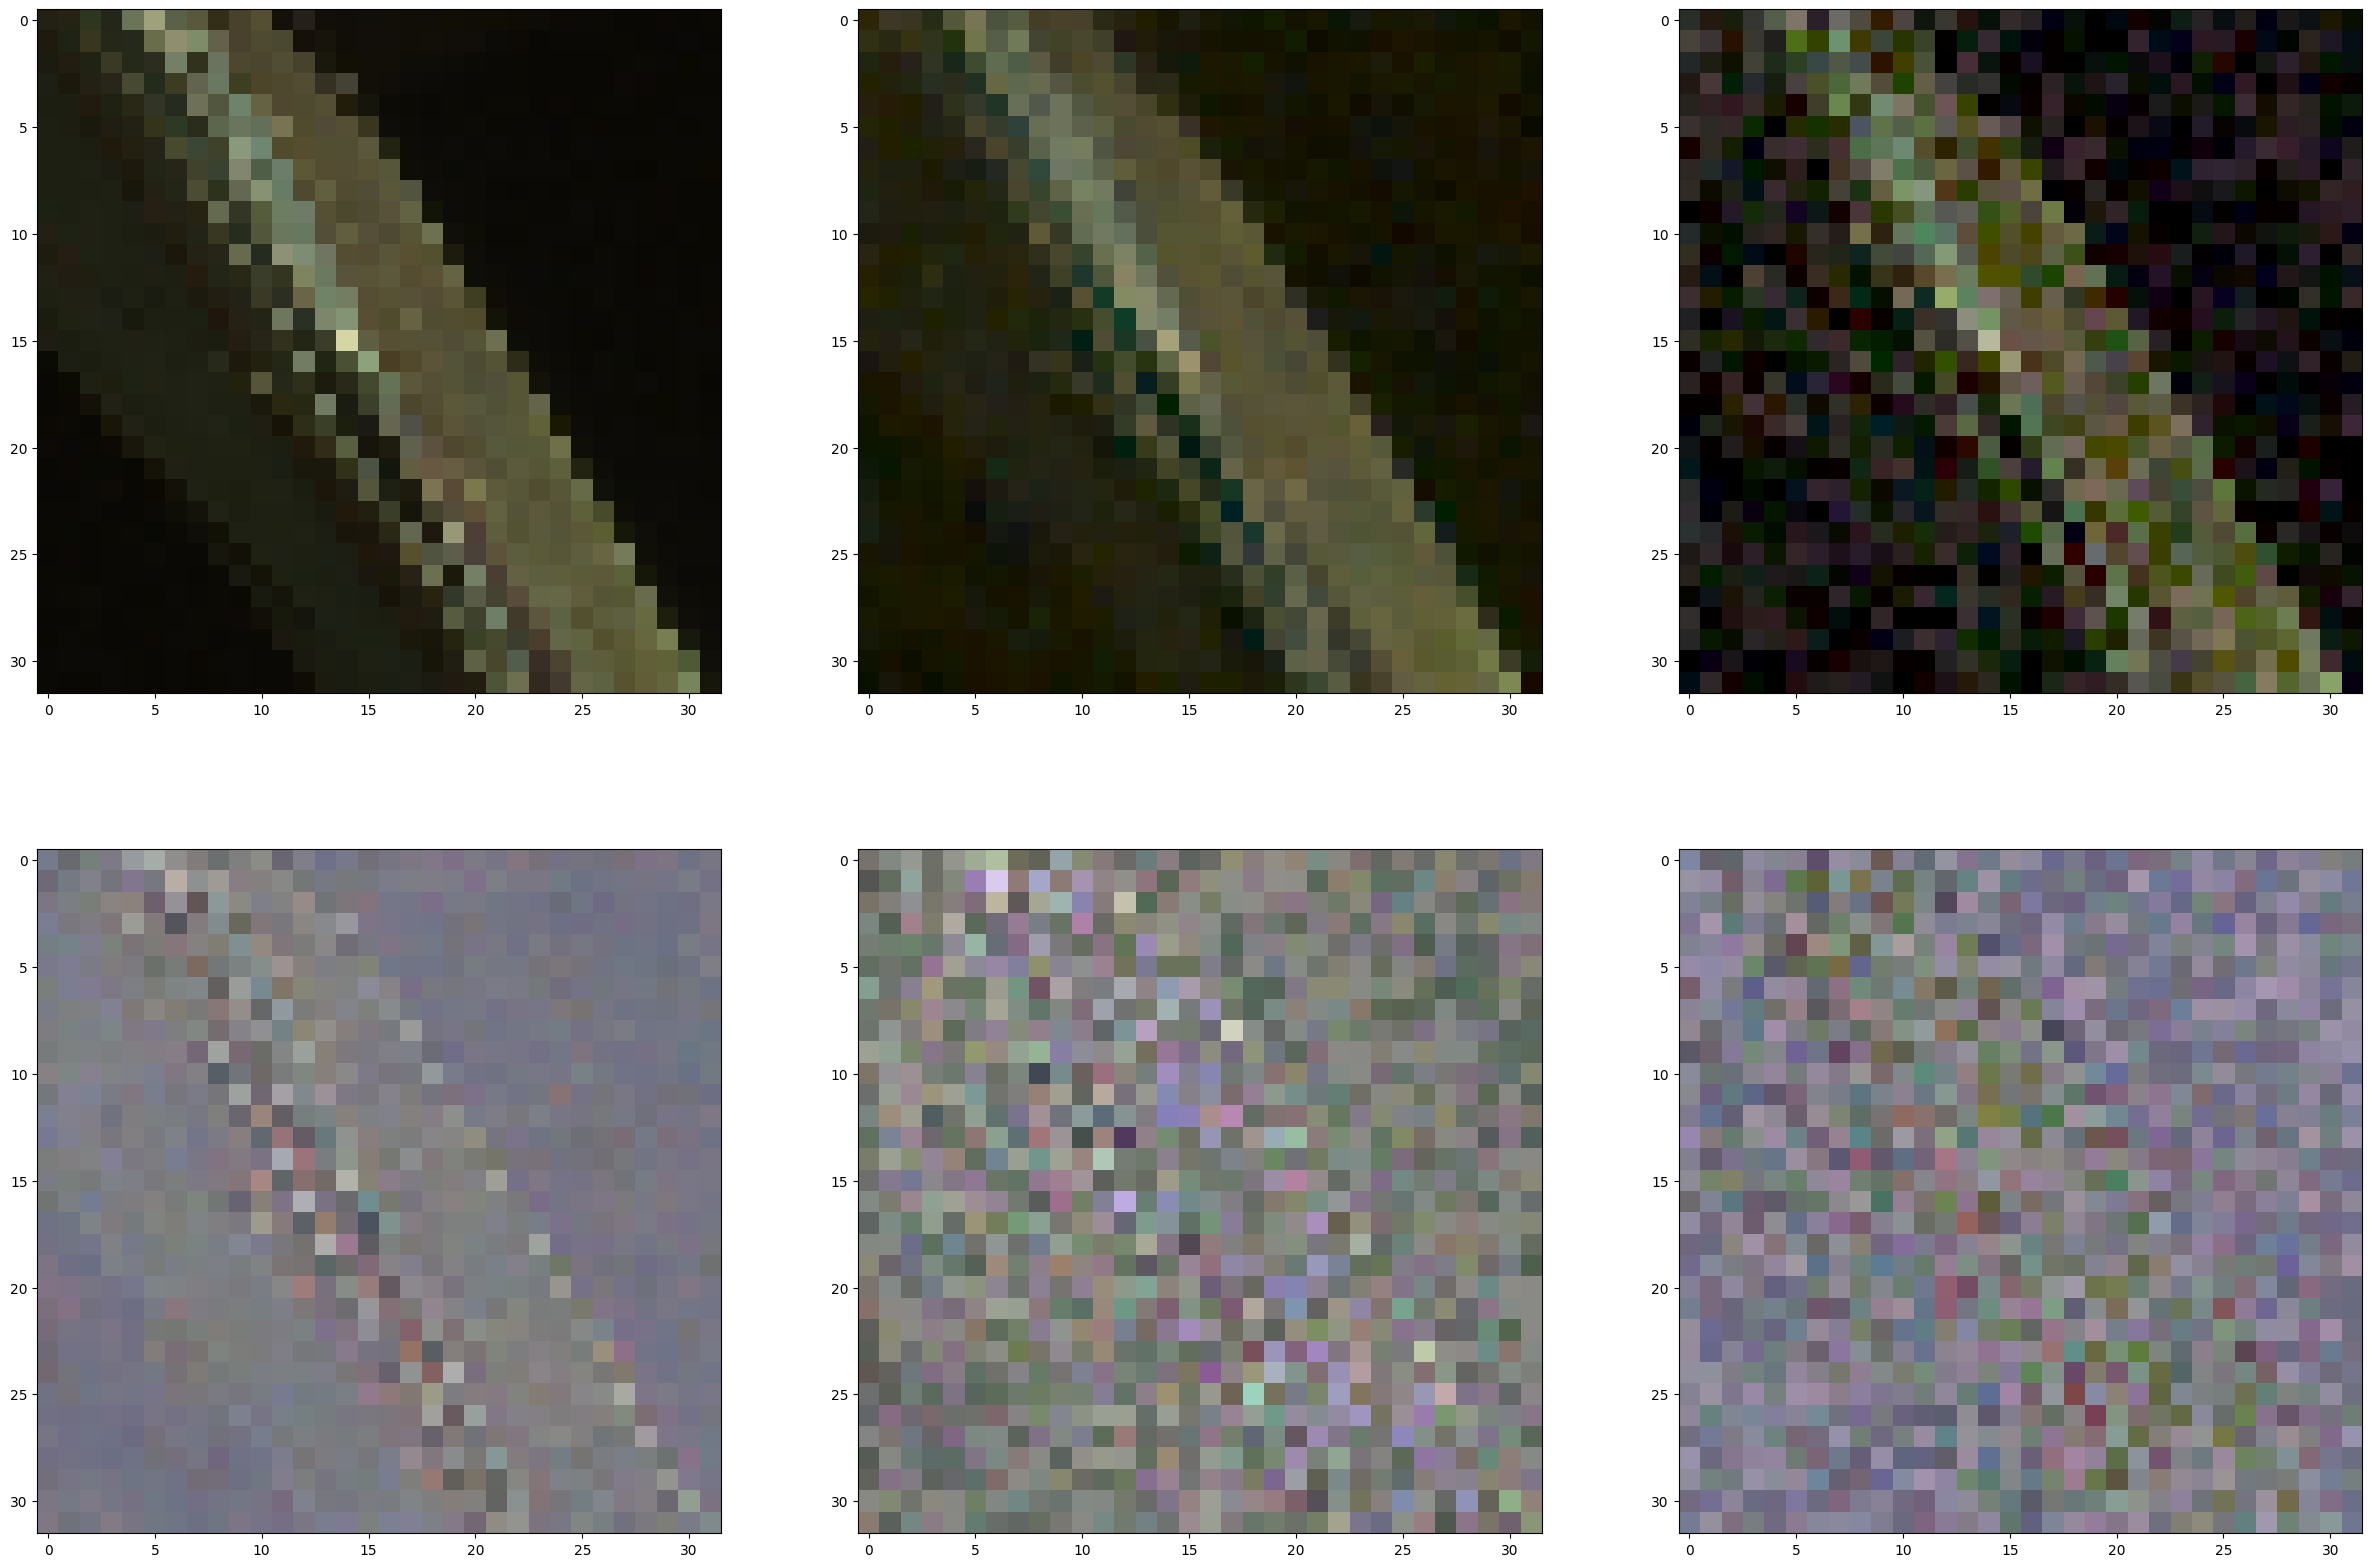

In [208]:
plt.subplots(2, 3, figsize=(30, 20))

x, y = 0, 0

crop = 200
plt.subplot(2,3,1)
plt.imshow(gt)

plt.subplot(2,3,2)
plt.imshow(out)

plt.subplot(2,3, 3)
plt.imshow(reduced_img)




plt.subplot(2,3, 4)
plt.imshow(gt-out+0.5)

plt.subplot(2,3, 5)
plt.imshow(gt-reduced_img+0.5)


plt.subplot(2,3, 6)
plt.imshow(reduced_img-out+0.5)


In [118]:
## Validaiton results

In [ ]:
model = ScaleAndProcess(3, 64, 3, 8, scale)
[Epoch 0] Val loss: 0.001972 Time: 31.1s Images: 319
[Epoch 1] Val loss: 0.001913 Time: 29.9s Images: 319
[Epoch 2] Val loss: 0.001913 Time: 29.7s Images: 319
# Speed test: 3.2 seconds

model = ScaleAndProcess(3, 64, 3, 8, enc_channels = [16, 32, 64])
[Epoch 0] Val loss: 0.002233 Time: 30.3s Images: 319
[Epoch 1] Val loss: 0.002076 Time: 30.4s Images: 319
[Epoch 2] Val loss: 0.002036 Time: 30.3s Images: 319

model = ScaleAndProcess(3, 64, 3, 8, enc_channels = [64, 64, 64])
[Epoch 0] Val loss: 0.002155 Time: 31.1s Images: 319
[Epoch 1] Val loss: 0.002095 Time: 30.7s Images: 319
[Epoch 2] Val loss: 0.002076 Time: 30.8s Images: 319

In [ ]:
# Conv next style block:
model = ScaleAndProcess(3, 64, 3, 12, scale)
3.1 seconds
It has a bit fewer computations than nafnet, so we can fit in more 12~8 in time


[Epoch 0] Val loss: 0.001984 Time: 32.8s Images: 319
[Epoch 1] Val loss: 0.002022 Time: 32.5s Images: 319
[Epoch 2] Val loss: 0.002053 Time: 31.4s Images: 319


# With GRN:
model = ScaleAndProcess(3, 64, 3, 8, scale)
3.2 seconds
[Epoch 0] Val loss: 0.001974 Time: 34.2s Images: 319
[Epoch 1] Val loss: 0.002108 Time: 34.4s Images: 319
[Epoch 2] Val loss: 0.001953 Time: 33.6s Images: 319

SyntaxError: invalid syntax (3523197248.py, line 3)

In [ ]:
CHASPABlock

model = ScaleAndProcess(3, 64, 3, 7, scale)
3.0 seconds
I'm surprised, cause it was testing as quicker than the NAF block before

[Epoch 0] Val loss: 0.001941 Time: 31.5s Images: 319
[Epoch 1] Val loss: 0.001723 Time: 31.7s Images: 319
[Epoch 2] Val loss: 0.001767 Time: 31.0s Images: 319

But it perfomred great!

In [ ]:
doubleconv block:

model = ScaleAndProcess(3, 64, 3, 13, scale)
3.1

[Epoch 0] Val loss: 0.001885 Time: 33.0s Images: 319
[Epoch 1] Val loss: 0.001827 Time: 31.6s Images: 319
[Epoch 2] Val loss: 0.001847 Time: 32.1s Images: 319

SyntaxError: invalid syntax (3594140971.py, line 1)

In [ ]:
doubleconv nka block:
model = ScaleAndProcess(3, 64, 3, 10, scale)
3.2


model = ScaleAndProcess(3, 64, 3, 8, scale)
[Epoch 0] Val loss: 0.001972 Time: 31.1s Images: 319
[Epoch 1] Val loss: 0.001913 Time: 29.9s Images: 319
[Epoch 2] Val loss: 0.001913 Time: 29.7s Images: 319
# Speed test: 3.2 seconds

model = ScaleAndProcess(3, 64, 3, 8, enc_channels = [16, 32, 64])
[Epoch 0] Val loss: 0.002233 Time: 30.3s Images: 319
[Epoch 1] Val loss: 0.002076 Time: 30.4s Images: 319
[Epoch 2] Val loss: 0.002036 Time: 30.3s Images: 319

model = ScaleAndProcess(3, 64, 3, 8, enc_channels = [64, 64, 64])
[Epoch 0] Val loss: 0.002155 Time: 31.1s Images: 319
[Epoch 1] Val loss: 0.002095 Time: 30.7s Images: 319
[Epoch 2] Val loss: 0.002076 Time: 30.8s Images: 319

In [ ]:
# Bottle neck
model = ScaleAndProcess(3, 64, 3, 14, scale) expand by 2

[Epoch 0] Val loss: 0.001912 Time: 32.6s Images: 319
[Epoch 1] Val loss: 0.001857 Time: 32.1s Images: 319
[Epoch 2] Val loss: 0.001787 Time: 31.9s Images: 319

#Bottle neck with two dw
model = ScaleAndProcess(3, 64, 3, 13 , scale)

[Epoch 0] Val loss: 0.001718 Time: 32.0s Images: 319
[Epoch 1] Val loss: 0.001935 Time: 31.6s Images: 319
[Epoch 2] Val loss: 0.002045 Time: 31.3s Images: 319

# With NKA
model = ScaleAndProcess(3, 64, 3, 10, scale)
[Epoch 0] Val loss: 0.001995 Time: 33.6s Images: 319
[Epoch 1] Val loss: 0.001713 Time: 31.6s Images: 319
[Epoch 2] Val loss: 0.001883 Time: 31.3s Images: 319

After 10 more:
[Epoch 0] Val loss: 0.001819 Time: 37.6s Images: 319
[Epoch 1] Val loss: 0.001649 Time: 31.6s Images: 319
[Epoch 2] Val loss: 0.001876 Time: 31.5s Images: 319


# With LKA

model = ScaleAndProcess(3, 64, 3, 11, scale)
[Epoch 0] Val loss: 0.001963 Time: 32.4s Images: 319
[Epoch 1] Val loss: 0.001758 Time: 32.1s Images: 319
[Epoch 2] Val loss: 0.001864 Time: 32.0s Images: 319

[Epoch 0] Val loss: 0.001747 Time: 31.5s Images: 319
[Epoch 1] Val loss: 0.001674 Time: 31.4s Images: 319
[Epoch 2] Val loss: 0.001988 Time: 31.1s Images: 319


# 128 width lka

model = ScaleAndProcess(3, 128, 3, 7, scale)

[Epoch 0] Val loss: 0.001771 Time: 31.8s Images: 319
[Epoch 1] Val loss: 0.001887 Time: 32.6s Images: 319
[Epoch 2] Val loss: 0.001881 Time: 33.2s Images: 319


[Epoch 0] Val loss: 0.001908 Time: 31.5s Images: 319
[Epoch 1] Val loss: 0.001761 Time: 31.2s Images: 319
[Epoch 2] Val loss: 0.001708 Time: 33.5s Images: 319

SyntaxError: invalid decimal literal (409590600.py, line 4)

In [37]:
(0.001787+ 0.001857+0.001912)/3

0.0018520000000000001